In [165]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# print(tf.__version__)

import os
import logging
import pickle
logging.basicConfig(filename="temp.log", filemode = "w", level=logging.INFO) # add filemode="w" to overwrite
from dataPull import getYfinData as getYfinData

## Function Definition

In [166]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Data Pull

In [167]:
# Data Pull
dataPullCfg = False
myTicker = 'NVDA'
tickerLst = ['XPO', 'BABA', 'NVDA', 'QQQ', 'ENPH']
# requestThd = 5
dateFilt = '2021-8-15'
# getData(tickerLst, requestThd, dateFilt) # Alpha Vantage
if dataPullCfg:
    getYfinData(tickerLst, None)

# -------------------------------------------------------------------- #

# Load Data from Disk
dir = os.getcwd()
dir = dir + "\\" + "stockData.file"
with open(dir, "rb") as f:
    dump = pickle.load(f)
    print("deserialization of " + dir + " complete...")

deserialization of c:\Users\malikf1\Desktop\DataScience\Local_Development\Personal_Projects\MLStockForecast\stockData.file complete...


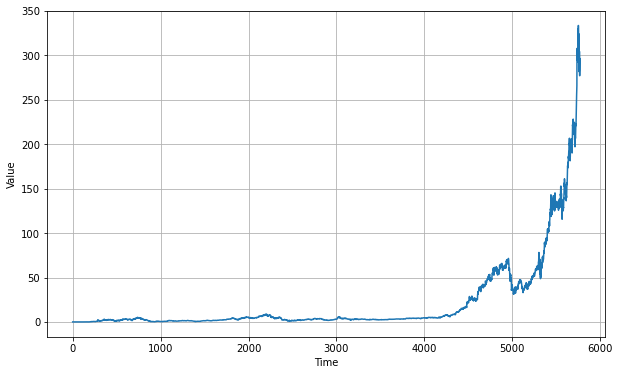

In [168]:
# dump['NVDA'] = dump['NVDA'].dropna()
# dump['NVDA'].reset_index(inplace=True, drop = True)
time = dump[myTicker].index.values #np.arange(len(dump['NVDA']), dtype="float32")
series = dump[myTicker]['close'].to_numpy()

plt.figure(figsize=(10, 6))
plot_series(time, series, start = None)

## Split Data and Configure Window, Batch, and Shuffle Size

In [169]:
# Train/Test Split
split_time = int(len(series)*0.70) # 4000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Single Layer Dense Neural Network

In [170]:
# https://keras.io/guides/sequential_model/
# Only for DNN
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series) # Create a dataset from the series
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # slice data up into appropriate windows, each shifted by one time stamp
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # flatten data out to make easier to work iwth. This will be flattened into chunks of window size. Basically make it into an array
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # Shuffle buffer speeds things up. 
  # Buffer Extra information: 100,000 items in dataset, set buffer to a 1000, it will just fill buffer with first 1000 elements and pick them at random. Then it will fill the second buffer with the second 1000 random elements. 
  # Then window so you have x's and y's separate
  dataset = dataset.batch(batch_size).prefetch(1) # here, the data is batched (given set of x's and y's based on batch_size)
  return dataset
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# for x,y in dataset:
#    print(x.numpy(), y.numpy())


In [171]:
# Only for DNN
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size]) # Single layer
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=50,verbose=1)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Epoch 1/50
67/67 [==============================] - 0s 4ms/step - loss: 18.3652
Epoch 2/50
67/67 [==============================] - 0s 3ms/step - loss: 9.8911
Epoch 3/50
67/67 [==============================] - 0s 3ms/step - loss: 5.3272
Epoch 4/50
67/67 [==============================] - 0s 3ms/step - loss: 2.9252
Epoch 5/50
67/67 [==============================] - 0s 3ms/step - loss: 1.6656
Epoch 6/50
67/67 [==============================] - 0s 3ms/step - loss: 1.0021
Epoch 7/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6533
Epoch 8/50
67/67 [==============================] - 0s 3ms/step - loss: 0.4701
Epoch 9/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3736
Epoch 10/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3229
Epoch 11/50
67/67 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 12/50
67/67 [==========================

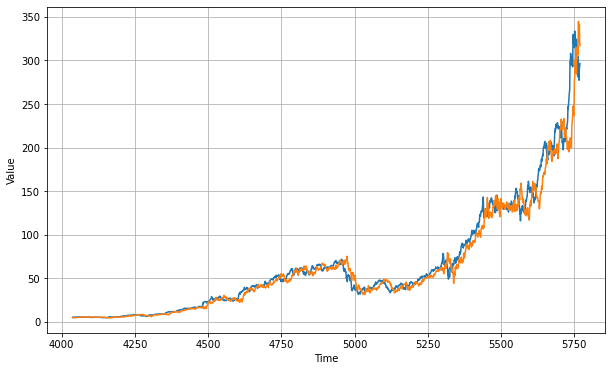

In [172]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [173]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.6209755

## Deep Dense Neural Networks (Multi-Layer)

In [174]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [175]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), # 10 neurons with relu activation function (first layer)
    tf.keras.layers.Dense(10, activation="relu"), # 10 neurons with relu activation function (second layer)
    tf.keras.layers.Dense(1) # 1 output?
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)
model.summary()


Epoch 1/100
67/67 [==============================] - 1s 3ms/step - loss: 4.5722
Epoch 2/100
67/67 [==============================] - 0s 3ms/step - loss: 3.8693
Epoch 3/100
67/67 [==============================] - 0s 3ms/step - loss: 3.2375
Epoch 4/100
67/67 [==============================] - 0s 3ms/step - loss: 2.6854
Epoch 5/100
67/67 [==============================] - 0s 3ms/step - loss: 2.2087
Epoch 6/100
67/67 [==============================] - 0s 3ms/step - loss: 1.8024
Epoch 7/100
67/67 [==============================] - 0s 3ms/step - loss: 1.4617
Epoch 8/100
67/67 [==============================] - 0s 3ms/step - loss: 1.1792
Epoch 9/100
67/67 [==============================] - 0s 3ms/step - loss: 0.9483
Epoch 10/100
67/67 [==============================] - 0s 3ms/step - loss: 0.7617
Epoch 11/100
67/67 [==============================] - 0s 3ms/step - loss: 0.6116
Epoch 12/100
67/67 [==============================] - 0s 3ms/step - loss: 0.4928
Epoch 13/100
67/67 [=================

In [176]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0] # Formatting thing


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

KeyboardInterrupt: 

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.399183

In [ ]:
# Learning Rate Schedule
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
125/125 [==============================] - 1s 3ms/step - loss: 4.4479 - lr: 1.0000e-08
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 4.4089 - lr: 1.1220e-08
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 4.3651 - lr: 1.2589e-08
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 4.3162 - lr: 1.4125e-08
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 4.2615 - lr: 1.5849e-08
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 4.2006 - lr: 1.7783e-08
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 4.1325 - lr: 1.9953e-08
Epoch 8/100
125/125 [==============================] - 0s 2ms/step - loss: 4.0563 - lr: 2.2387e-08
Epoch 9/100
125/125 [==============================] - 0s 2ms/step - loss: 3.9710 - lr: 2.5119e-08
Epoch 10/100
125/125 [==============================] - 0s 2ms/step - loss: 3.8755 - lr: 2.8184e-08
Epoch 11/

(1e-05, 0.001, 0.0, 0.2)

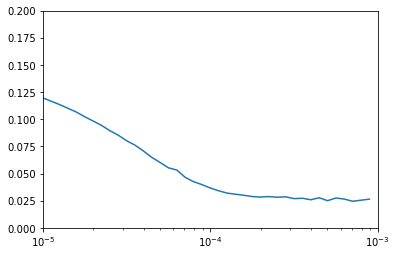

In [ ]:
# loss vs learning rate
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-5, 1e-3, 0, 0.2])

In [123]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [27]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

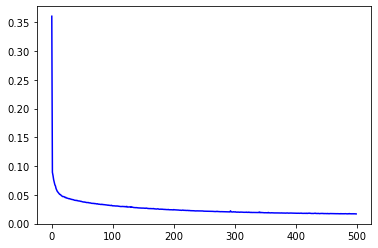

In [28]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

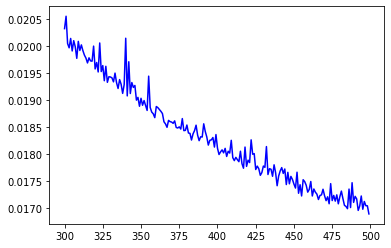

In [31]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(300, len(loss))
plot_loss = loss[300:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

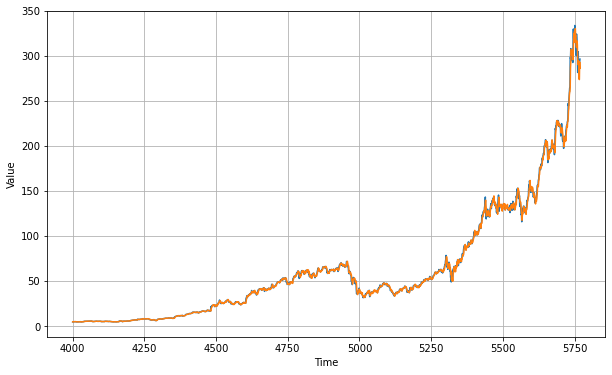

In [32]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [39]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1.5019423

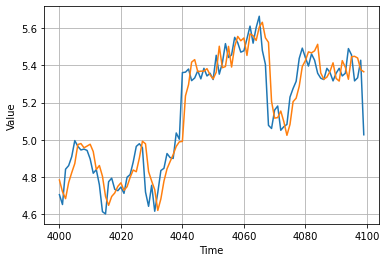

In [51]:

plot_series(time_valid, x_valid, end = 100)
plot_series(time_valid, results, end = 100)

In [64]:
len(series[4000:])

1770

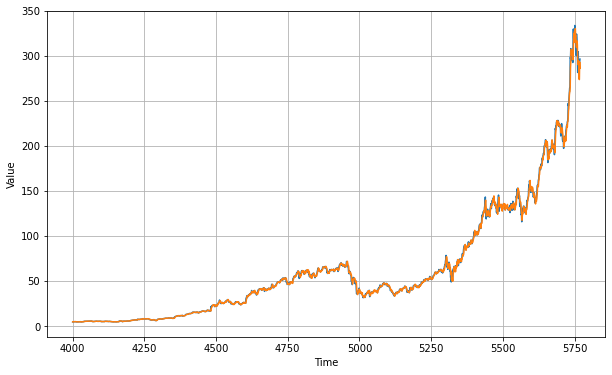

In [73]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

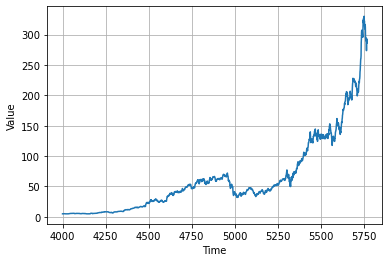

In [74]:
plot_series(time_valid, results)

In [68]:
len(results)

1740

In [69]:
len(time_valid)

1770